In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.cm as cm

import numpy as np

import skimage.transform
from scipy import ndimage
import scipy.misc

def image_show(image_path):
  imshow(np.asarray(Image.open(image_path, 'r')))
  plt.axis('off')
  plt.show()

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS

#flags.DEFINE_string('model_dir', '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.finetune/', '')
  
import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import algos_factory
from deepiu.seq2seq.rnn_decoder import SeqDecodeMethod

#debug
from deepiu.util import text2ids

TEXT_MAX_WORDS = 100    
decode_max_words = 20


from deepiu.util import ids2text
vocab_path = '/home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt'
ids2text.init(vocab_path)

image_dir = image_dir = '/home/gezi/data2/data/ai_challenger/image_caption/pic/'
image_file = '6275b5349168ac3fab6a493c509301d023cf39d3.jpg'
image_path = os.path.join(image_dir, image_file)
image_model_checkpoint_path = '/home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt'
net = melt.image.get_imagenet_from_checkpoint(FLAGS.image_checkpoint_file)
print('image net', net, 'net.default_image_size', net.default_image_size)
FLAGS.image_model_name = FLAGS.image_model_name or net.name
FLAGS.image_height = FLAGS.image_height or net.default_image_size
FLAGS.image_width = FLAGS.image_width or net.default_image_size
image_model_name = FLAGS.image_model_name

#FLAGS.model_dir = model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell2.finetune/'
FLAGS.model_dir = model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model.v3.main/showattentell.finetune.baseline/'


if not melt.varname_in_checkpoint(image_model_name, model_dir):
  image_model = melt.image.ImageModel(image_model_checkpoint_path, 
                                      model_name=image_model_name)
else:
  image_model = None

import libpinyin
pinyin = libpinyin.Pinyin()
pinyin.Load('./data/pinyin/')

tensorflow_version: 1.4.0-rc1


INFO:tensorflow:Initializing vocabulary from file: /home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt
INFO:tensorflow:Created vocabulary with 10148 words
image net <function inception_resnet_v2 at 0x7f22913dee60> net.default_image_size 299


ENCODE_UNK 1


In [2]:
if 'coverage' in model_dir:
  FLAGS.coverage_attention_wrapper = True

FLAGS.image_encoder = 'Rnn'
FLAGS.showtell_encode_scope = 'encode'
FLAGS.showtell_decode_scope = 'decode'
FLAGS.image_attention_size = 64 
FLAGS.image_endpoint_feature_name = 'Conv2d_7b_1x1'
FLAGS.image_model = 'InceptionResnetV2'
FLAGS.image_checkpoint_file = '/home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt' 
FLAGS.pre_calc_image_feature = 0 
FLAGS.finetune_image_model = True 
FLAGS.image_features_batch_norm = True 
FLAGS.image_features_drop_out = True
FLAGS.emb_dim = 512 
FLAGS.rnn_hidden_size = 512 
FLAGS.image_feature_len = 1536 * 64
FLAGS.alignment_history = True

beam_size = 100
length_normalization_factor = 0.25

In [3]:
algo = 'show_and_tell'
global_scope = algo
main_scope = 'main'
melt.apps.image_processing.init()
with tf.variable_scope(global_scope):
  with tf.variable_scope(main_scope):
    predictor =  algos_factory.gen_predictor(algo)
    predictor.init_predict_text(decode_method=SeqDecodeMethod.ingraph_beam, 
                                beam_size=beam_size,
                                length_normalization_factor=length_normalization_factor,
                                logprobs_history=True,
                                alignment_history=True)  

predictor.load(FLAGS.model_dir) 

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


cell: <class 'tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell'>
cell: <class 'tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell'>
rnn decoder gen only mode
preprocessing_fn net_name inception_resnet_v2 height 299 width 299
image_model will get feature_name Conv2d_7b_1x1
image_feature: Tensor("show_and_tell/main/encode/Flatten/flatten/Reshape:0", shape=(?, 98304), dtype=float32)
attention_mechanism: <melt.seq2seq.attention_wrapper.LuongAttention object at 0x7f2215eecb50>


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/image-caption/ai-challenger/model.v3.main/showattentell.finetune.baseline/model.ckpt-30.35-487000


restore ok: /home/gezi/new/temp/image-caption/ai-challenger/model.v3.main/showattentell.finetune.baseline/model.ckpt-30.35-487000
load model ok /home/gezi/new/temp/image-caption/ai-challenger/model.v3.main/showattentell.finetune.baseline/model.ckpt-30.35-487000 duration: 13.3749849796


In [4]:
def simple_predict(image_path, predictor):
  timer = gezi.Timer('beam search using time')
  img = melt.read_image(image_path)
  if image_model:
    #attention model gen features only
    feature = image_model.gen_features(img) if image_model is not None else img
  else:
    feature = [img]    
  #texts_list, scores_list = predictor.predict_text(feature)
  #timer.print()
  logprobs_history = None 
  alignment_history = None

  l = predictor.predict_text(feature)
  timer.print()
  texts_list, scores_list= l[0], l[1]
  try:
    logprobs_history = l[2]
    alignment_history = l[3]
  except Exception:
    pass

  #print(alignment_history)

  texts = texts_list[0]
  scores = scores_list[0]
  if logprobs_history is not None:
    logprobs = logprobs_history[0]
  else:
    logprobs = [None] * len(texts)
  if alignment_history is not None:
    alignments = alignment_history[0]
  else:
    alignments = [None] * len(texts)
    
  logprob = None 
  alignment = None 
    
  for text, score, logprob, alignment in zip(texts, scores, logprobs, alignments):
    print('align shape', alignment.shape)
    print(ids2text.ids2text(text), score)
    print(text, len(text))
    if logprob is not None:
      print(map(math.exp, logprob))
    #if alignment is not None:
    #  print(alignment)
    #  print(alignment[10], alignment[11], alignment[12])


In [5]:
#simple_predict(image_path, predictor)

In [6]:
def predict(image_path, predictor, length_normalization_factor=0.25, num_show=1):
  img = melt.read_image(image_path)
  if image_model:
    feature = image_model.gen_feature(img) if image_model is not None else img
  else:
    feature = [img]

  timer = gezi.Timer()
  texts, scores, logprobs_history, alignment_history = predictor.predict_text(feature)
  for i, (text, score, logprob, alignment) in enumerate(zip(texts[0], scores[0], logprobs_history[0], alignment_history[0])):
    print(ids2text.ids2text(text), score)

    # Plot images with attention weights
    words = ids2text.ids2words(text) 
    img = ndimage.imread(image_path)
    
    num_features = melt.image.get_num_features(image_model_name)
    dim = int(np.sqrt(num_features))
    #print('dim:', dim)

    n_words = len(words)
    n_words += 1 #for ori image
    w = np.round(np.sqrt(n_words))
    h = np.ceil(np.float32(n_words) / w)
    
    #print(n_words, w, h)
            
    plt.subplot(w, h, 1)
    plt.imshow(img)
    plt.axis('off')

    #img = scipy.misc.imresize(img, (dim, dim))  

    #smooth = True  #TODO smooth = Ture seems not work not back ground pic
    smooth = False
    if i < 10:  
      print('probs', [math.exp(x) for x in logprob])
      for j in range(len(words)):
        #if i == 0:
        #  print(i, j, words[j], alignment[j])
        plt.subplot(w, h, j + 2)
        lab = pinyin.Convert(words[j].decode('utf8').encode('gbk'))
        lab += '(%0.2f)'%math.exp(logprob[j])
        plt.text(0, 1, lab, backgroundcolor='white', fontsize=10)
        plt.text(0, 1, lab, color='black', fontsize=10)
        plt.imshow(img)
        if smooth:
          alpha_img = skimage.transform.pyramid_expand(alignment[j].reshape(dim, dim), upscale=16, sigma=20)
        else:
          alpha_img = skimage.transform.resize(alignment[j].reshape(dim, dim), [img.shape[0], img.shape[1]])
        plt.imshow(alpha_img, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
      plt.show()
      #plt.savefig('test%d.pdf'%i)

    print('beam search using time(ms):', timer.elapsed_ms())

In [ ]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: 0d5bb5c1fcebec433bdd5a636c85e907d0d40535


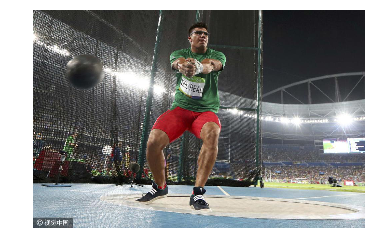

一个 穿着 运动服 的 男人 在 运动场 上 腾空 跃起 </S> 0.0890283
probs [0.5658658942826108, 0.6645541631242897, 0.5232004853485573, 0.9701839254173074, 0.8211144659703211, 0.8709164433002758, 0.713675469932183, 0.8801372036313599, 0.2313769478766614, 0.630461696463044, 0.9766654643652203, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


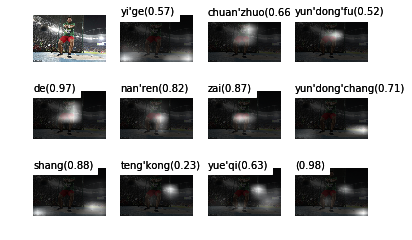

beam search using time(ms): 6560.59408188
一个 穿着 运动服 的 男人 在 运动场 上 跳跃 </S> 0.0619837
probs [0.5658658942826108, 0.6645541631242897, 0.5232004853485573, 0.9701839254173074, 0.8211144659703211, 0.8709164433002758, 0.713675469932183, 0.8801372036313599, 0.08476127623538289, 0.9793482011668042, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


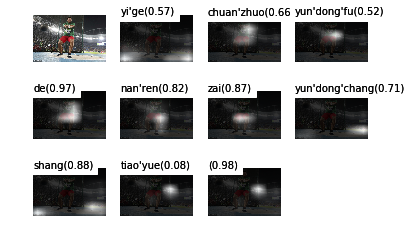

beam search using time(ms): 5397.01700211
一个 穿着 运动服 的 男人 在 运动场 上 举重 </S> 0.0572999
probs [0.5658658942826108, 0.6645541631242897, 0.5232004853485573, 0.9701839254173074, 0.8211144659703211, 0.8709164433002758, 0.713675469932183, 0.8801372036313599, 0.07446958993955101, 0.9693371697226273, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


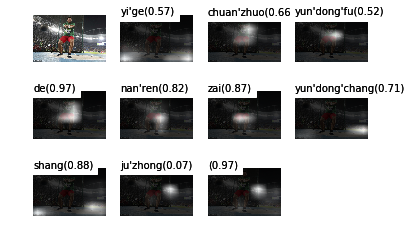

beam search using time(ms): 1813.99703026
运动场 上 有 一个 穿着 运动服 的 男人 在 举重 </S> 0.0556114
probs [0.16866485130184425, 0.875321981066046, 0.7695744638165875, 0.9631775484046438, 0.7495110036304504, 0.5627160443872267, 0.9956121703035357, 0.9137035340051364, 0.9562508195553896, 0.13007677667408532, 0.9927920098032875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


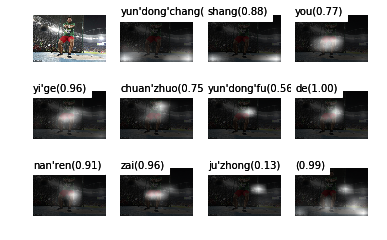

beam search using time(ms): 1483.37197304
运动场 上 有 一个 穿着 运动服 的 男人 在 跳跃 </S> 0.0466782
probs [0.16866485130184425, 0.875321981066046, 0.7695744638165875, 0.9631775484046438, 0.7495110036304504, 0.5627160443872267, 0.9956121703035357, 0.9137035340051364, 0.9562508195553896, 0.09468504679524642, 0.9914675904837836, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


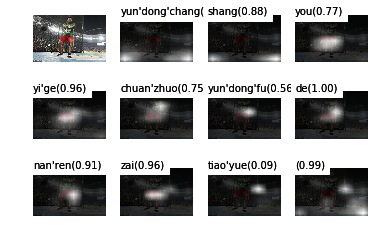

beam search using time(ms): 3402.71401405
一个 穿着 运动服 的 男人 在 运动场 上 腾空 跳 起 </S> 0.0458386
probs [0.5658658942826108, 0.6645541631242897, 0.5232004853485573, 0.9701839254173074, 0.8211144659703211, 0.8709164433002758, 0.713675469932183, 0.8801372036313599, 0.2313769478766614, 0.1773896637505625, 0.9286824038512267, 0.9861841944789889, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


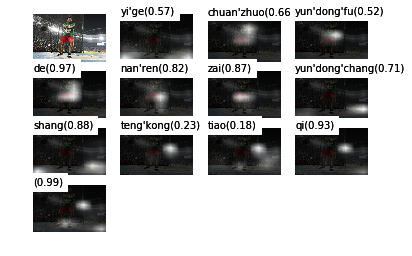

beam search using time(ms): 2643.93401146
一个 穿着 运动服 的 男人 在 运动场 上 腾空 跳跃 </S> 0.0438342
probs [0.5658658942826108, 0.6645541631242897, 0.5232004853485573, 0.9701839254173074, 0.8211144659703211, 0.8709164433002758, 0.713675469932183, 0.8801372036313599, 0.2313769478766614, 0.17342674734544944, 0.9769920383265598, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


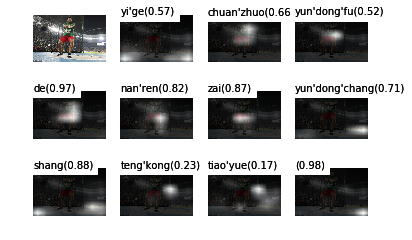

beam search using time(ms): 2286.76486015
一个 穿着 运动装 的 男人 在 运动场 上 腾空 跃起 </S> 0.0437966
probs [0.5658658942826108, 0.6645541631242897, 0.13657015392938004, 0.987412579496154, 0.8989424235646116, 0.8883935364832178, 0.7682083784391316, 0.8765624566422755, 0.22554697698331083, 0.5576349319246996, 0.9784991900746283, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


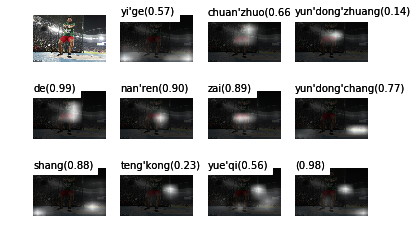

beam search using time(ms): 2023.10299873
一个 穿着 运动服 的 男人 在 运动场 上 奔跑 </S> 0.0419153
probs [0.5658658942826108, 0.6645541631242897, 0.5232004853485573, 0.9701839254173074, 0.8211144659703211, 0.8709164433002758, 0.713675469932183, 0.8801372036313599, 0.04453555761055435, 0.9295861825091528, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


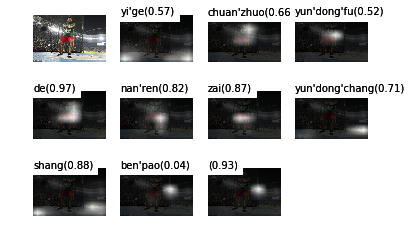

beam search using time(ms): 1414.0150547
一个 穿着 运动服 的 男人 站 在 运动场 上 </S> 0.0407268
probs [0.5658658942826108, 0.6645541631242897, 0.5232004853485573, 0.9701839254173074, 0.8211144659703211, 0.03929405915114085, 0.9995682912057001, 0.7311447520827472, 0.918977235704318, 0.8153834673380889, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


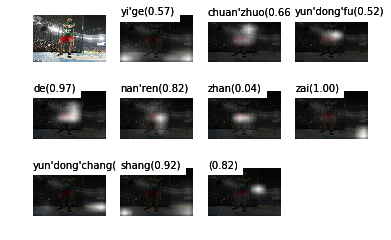

beam search using time(ms): 1956.60591125
一个 穿着 运动衣 的 男人 在 运动场 上 腾空 跃起 </S> 0.0398078
beam search using time(ms): 48.2230186462
一个 穿着 运动服 的 男人 在 运动场 上 跑步 </S> 0.0361042
beam search using time(ms): 32.3460102081
运动场 上 有 一个 穿着 运动装 的 男人 在 举重 </S> 0.0354484
beam search using time(ms): 25.4650115967
一个 穿着 运动服 的 男人 在 运动场 上 竞走 </S> 0.0346575
beam search using time(ms): 27.0531177521
运动场 上 有 一个 穿着 运动服 的 男人 在 竞走 </S> 0.0344999
beam search using time(ms): 26.5438556671
一个 穿着 运动装 的 男人 在 运动场 上 举重 </S> 0.0340315
beam search using time(ms): 25.6450176239
一个 穿着 运动衣 的 男人 在 运动场 上 举重 </S> 0.0331354


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


beam search using time(ms): 27.7531147003
一个 穿着 运动服 的 男人 在 运动场 上 跳远 </S> 0.0318989
beam search using time(ms): 24.68085289
一个 穿着 运动服 的 男人 在 运动场 上 呐喊 </S> 0.0312638
beam search using time(ms): 24.9571800232
运动场 上 有 一个 穿着 运动服 的 男人 在 举 杠铃 </S> 0.0309631
beam search using time(ms): 50.9397983551
运动场 上 有 一个 穿着 运动服 的 男人 在 跑步 </S> 0.0290267
beam search using time(ms): 47.2240447998
一个 穿着 运动服 的 男人 在 运动场 上 跨栏 </S> 0.0278636
beam search using time(ms): 26.0851383209
一个 穿着 运动装 的 男人 在 运动场 上 腾空 跳 起 </S> 0.0266437
beam search using time(ms): 58.7539672852
运动场 上 有 一个 穿着 运动服 的 男人 在 奔跑 </S> 0.0266143
beam search using time(ms): 80.3928375244
运动场 上 有 一个 穿着 运动服 的 男人 在 跳远 </S> 0.0264751
beam search using time(ms): 41.9681072235
运动场 上 有 一个 穿着 运动装 的 男人 在 跳跃 </S> 0.0256426
beam search using time(ms): 46.7500686646
一个 穿着 运动装 的 男人 在 运动场 上 腾空 跳跃 </S> 0.0252814
beam search using time(ms): 25.9108543396
一个 穿着 运动衣 的 男人 在 运动场 上 腾空 跳跃 </S> 0.0250729
beam search using time(ms): 23.6649513245
一个 双手 抬起 的 男人 在 运动场 上 腾空 

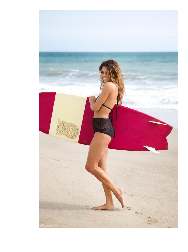

一个 穿着 比基尼 的 女人 走 在 海边 的 沙滩 上 </S> 0.13524
probs [0.6267006473897423, 0.3734573406258064, 0.4178974817643815, 0.9039945072882566, 0.9041965008115501, 0.5148693898531508, 0.9956935933066222, 0.6142434478694719, 0.9828456200867653, 0.9837656421148454, 0.9949016761483196, 0.996972100887296, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


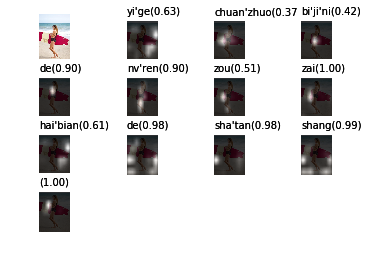

beam search using time(ms): 7834.13314819
一个 双手 拿 着 冲浪板 的 女人 走 在 海边 的 沙滩 上 </S> 0.103574
probs [0.6267006473897423, 0.1840537776646816, 0.4066076692447341, 0.9980474760828026, 0.8450845105286012, 0.9673406644850611, 0.966100040809708, 0.7320934635536968, 0.9990362880606635, 0.49971377009533285, 0.9478082296201823, 0.9853155400885942, 0.9878110497453092, 0.9988216949665017, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


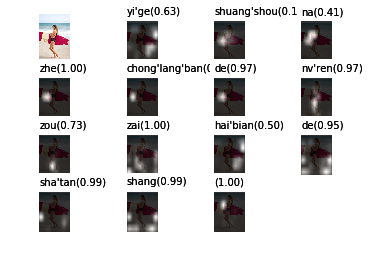

beam search using time(ms): 3122.99895287
一个 穿着 泳衣 的 女人 走 在 海边 的 沙滩 上 </S> 0.101044
probs [0.6267006473897423, 0.3734573406258064, 0.26028939399837153, 0.8909129226759529, 0.8797401296741838, 0.4984120653965752, 0.9959064893246445, 0.6169474126455253, 0.9832999986465631, 0.9841136061316196, 0.9949082840355294, 0.9969328828684766, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


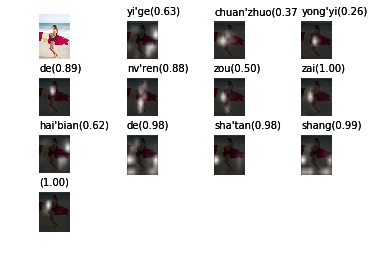

beam search using time(ms): 1503.29709053
一个 双手 抱 着 冲浪板 的 女人 走 在 海边 的 沙滩 上 </S> 0.0822318
probs [0.6267006473897423, 0.1840537776646816, 0.24607496825083103, 0.9291397317625573, 0.9585523589527235, 0.9772046383432356, 0.959285906605375, 0.7043177276120902, 0.9988258573840769, 0.522687958648417, 0.9367648090756411, 0.9873507503119893, 0.9893879676328895, 0.9991930088188641, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


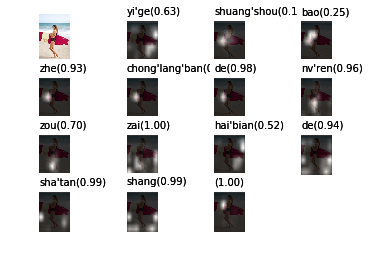

beam search using time(ms): 2230.96084595
一个 右手 拿 着 冲浪板 的 女人 走 在 海边 的 沙滩 上 </S> 0.0821019
probs [0.6267006473897423, 0.06475230665331376, 0.7821666956706044, 0.9982326327046207, 0.8538333627916793, 0.9536870042064544, 0.9487860088063239, 0.7978136814145805, 0.9992883504830979, 0.449885352776161, 0.9326065989062704, 0.9854596495902183, 0.9856306690212372, 0.9987457053194481, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


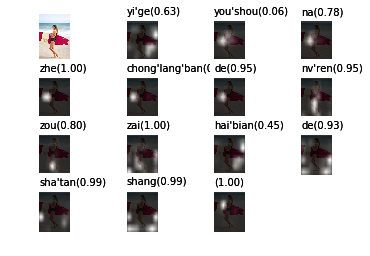

beam search using time(ms): 1517.09103584
海边 的 沙滩 上 走 着 一个 穿着 比基尼 的 女人 </S> 0.0775028
probs [0.11638601405802612, 0.7860238101511281, 0.9774352102335528, 0.9923424351391844, 0.6993252047095737, 0.9994382439611917, 0.8507235449712593, 0.30726732622067826, 0.5761112214867204, 0.9717040094823901, 0.9475073985992108, 0.9961806343699486, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


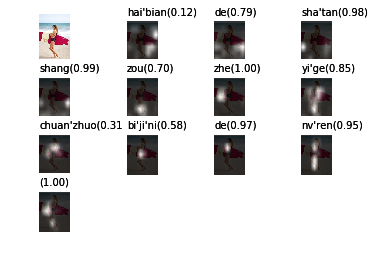

beam search using time(ms): 1394.32096481
一个 长 头发 的 女人 走 在 海边 的 沙滩 上 </S> 0.068682
probs [0.6267006473897423, 0.04810698068298318, 0.9916118646524904, 0.9565603918107815, 0.9677187441772387, 0.41748932911593745, 0.9969949697049509, 0.6250113960887694, 0.9795104716092262, 0.9827217284496585, 0.9923358613910042, 0.9947741381158047, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


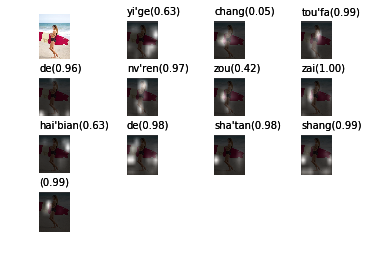

beam search using time(ms): 1190.04511833
一个 双手 拿 着 冲浪板 的 女人 走 在 沙滩 上 </S> 0.0621647
probs [0.6267006473897423, 0.1840537776646816, 0.4066076692447341, 0.9980474760828026, 0.8450845105286012, 0.9673406644850611, 0.966100040809708, 0.7320934635536968, 0.9990362880606635, 0.21851018312800338, 0.981163333190246, 0.9802512625872842, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


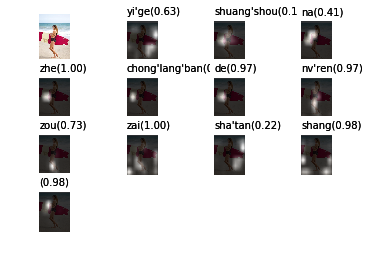

beam search using time(ms): 1273.66089821
一个 穿着 比基尼 的 女人 站 在 海边 的 沙滩 上 </S> 0.0585972
probs [0.6267006473897423, 0.3734573406258064, 0.4178974817643815, 0.9039945072882566, 0.9041965008115501, 0.1232917971192299, 0.9985682036810672, 0.5680569629555288, 0.9818277880953435, 0.9742935464572119, 0.9895361894894805, 0.961834187666038, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


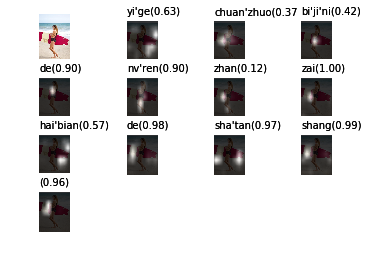

beam search using time(ms): 1283.41007233
一个 披 着 长发 的 女人 走 在 海边 的 沙滩 上 </S> 0.0564816
probs [0.6267006473897423, 0.04359116813426308, 0.9960910888438397, 0.47841653478238433, 0.9694419106335894, 0.9650505157666752, 0.6151960183330808, 0.9967435891575825, 0.5950066943849194, 0.9842743414694861, 0.9835466041622376, 0.9941404716006508, 0.9976342985113581, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


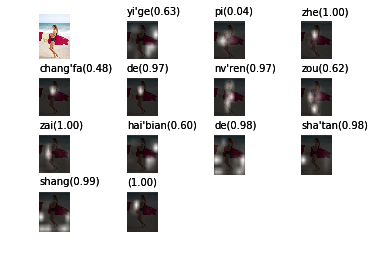

beam search using time(ms): 1467.91601181
沙滩 上 走 着 一个 双手 拿 着 冲浪板 的 女人 </S> 0.0540944
beam search using time(ms): 53.5709857941
一个 穿着 泳装 的 女人 走 在 海边 的 沙滩 上 </S> 0.0520937
beam search using time(ms): 25.3858566284
一个 右手 拿 着 冲浪板 的 女人 走 在 沙滩 上 </S> 0.0518941
beam search using time(ms): 25.5870819092
一个 披 着 头发 的 女人 走 在 海边 的 沙滩 上 </S> 0.0517025
beam search using time(ms): 25.1071453094
一个 左手 拿 着 冲浪板 的 女人 走 在 海边 的 沙滩 上 </S> 0.0506278
beam search using time(ms): 26.9079208374
一个 穿着 短裤 的 女人 走 在 海边 的 沙滩 上 </S> 0.0490928
beam search using time(ms): 29.7350883484
海边 的 沙滩 上 走 着 一个 双手 拿 着 冲浪板 的 女人 </S> 0.0466703
beam search using time(ms): 25.0189304352
一个 双手 拿 着 冲浪板 的 女人 走 在 柔软 的 沙滩 上 </S> 0.0462371
beam search using time(ms): 23.4279632568
一个 双手 抱 着 冲浪板 的 女人 走 在 沙滩 上 </S> 0.0447352
beam search using time(ms): 25.2819061279
一个 穿着 泳衣 的 女人 站 在 海边 的 沙滩 上 </S> 0.0437892
beam search using time(ms): 24.649143219
一个 双手 拿 着 冲浪板 的 女人 站 在 海边 的 沙滩 上 </S> 0.043544
beam search using time(ms): 25.4719257355
一个 穿

In [ ]:
while True:
  image_name = raw_input('image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: ')
  image_name = image_name.strip().replace('file://', '')
  if image_name == 'q':
    break
  if not image_name.endswith('.jpg'):
    image_name += '.jpg'

  image_path = os.path.join(image_dir, image_name)

  if not os.path.exists(image_path):
    print('path not exists:%s'%image_path)
    image_path = image_name
    if not os.path.exists(image_path):
        continue
  plt.subplot(1, 1, 1)
  image_show(image_path)
  predict(image_path, predictor)
  #predict(image_path, predictor2, gen_feature=False)

In [ ]:
import glob 
for img in glob.glob('/home/gezi/new2/data/ai_challenger/image_caption/test_pic/*.jpg'):
    image_show(img)
    predict(img, predictor)